# Subsampling Cache Visualisation

Inspect cached subsample windows produced by `C1_dRSA_run.py`.
Update `cache_path` in the configuration cell to explore other runs.

In [7]:
# Imports (run once per session)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import ticker
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


In [8]:
# Configuration
cache_path = Path('results/cache/subsamples/subsamples_60238e338e7311d62511b0c3681ef88cb0643ea0.npy')
indices = np.load(cache_path)
iterations, n_subsamples, subsample_tps = indices.shape
print(f'Loaded {cache_path}')
print(f'Shape: {indices.shape} (iterations, subsamples, window length)')


Loaded results/cache/subsamples/subsamples_60238e338e7311d62511b0c3681ef88cb0643ea0.npy
Shape: (100, 150, 500) (iterations, subsamples, window length)


In [ ]:
# Optional: load sentence mask and word onsets (adjust subject and paths as needed)
subject = 'sub-01'
mask_path = Path(f'derivatives/preprocessed/{subject}/concatenated/{subject}_concatenated_sentence_mask_100Hz.npy')
if mask_path.exists():
    sentence_mask = np.load(mask_path).astype(bool)
    mask_seconds = np.arange(sentence_mask.size) / 100.0
else:
    sentence_mask = None
    mask_seconds = None
word_onsets_path = Path(f'derivatives/preprocessed/{subject}/concatenated/{subject}_concatenated_word_onsets_sec.npy')
if word_onsets_path.exists():
    subject_onsets = np.load(word_onsets_path)
else:
    subject_onsets = np.empty(0, dtype=float)
dt = 1.0 / 100.0

def shade_mask_regions(ax, times, mask, dt, label=None):
    if mask is None:
        return
    mask = np.asarray(mask, dtype=bool)
    if mask.size == 0 or not mask.any():
        return
    sample_count = min(len(times), mask.size)
    if sample_count == 0:
        return
    times = np.asarray(times)[:sample_count]
    mask = mask[:sample_count]
    diffs = np.diff(np.concatenate(([False], mask, [False])))
    starts = np.where(diffs == 1)[0]
    ends = np.where(diffs == -1)[0]
    for idx, (s_idx, e_idx) in enumerate(zip(starts, ends)):
        start_t = times[s_idx]
        end_idx = min(e_idx, sample_count)
        end_t = times[end_idx - 1] + dt
        ax.axvspan(start_t, end_t, color='gold', alpha=0.12, edgecolor=None, linewidth=0, zorder=3, label=label if label and idx == 0 else None)


In [9]:
# Build coverage matrix (rows = iterations, columns = absolute sample indices)
t_max = indices.max() + subsample_tps
canvas = np.zeros((iterations, t_max), dtype=np.int32)

for it in range(iterations):
    for window in indices[it]:
        start = window[0]
        canvas[it, start:start + subsample_tps] += 1

base_colors = ['white', '#440154', '#31688E', '#35B779', '#FDE725', '#FDAE61']
max_overlap = int(canvas.max())
if max_overlap >= len(base_colors):
    extra = max_overlap + 1 - len(base_colors)
    base_colors.extend([base_colors[-1]] * extra)
cmap = ListedColormap(base_colors[: max_overlap + 1])
bounds = np.arange(-0.5, max_overlap + 1.5, 1)
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)


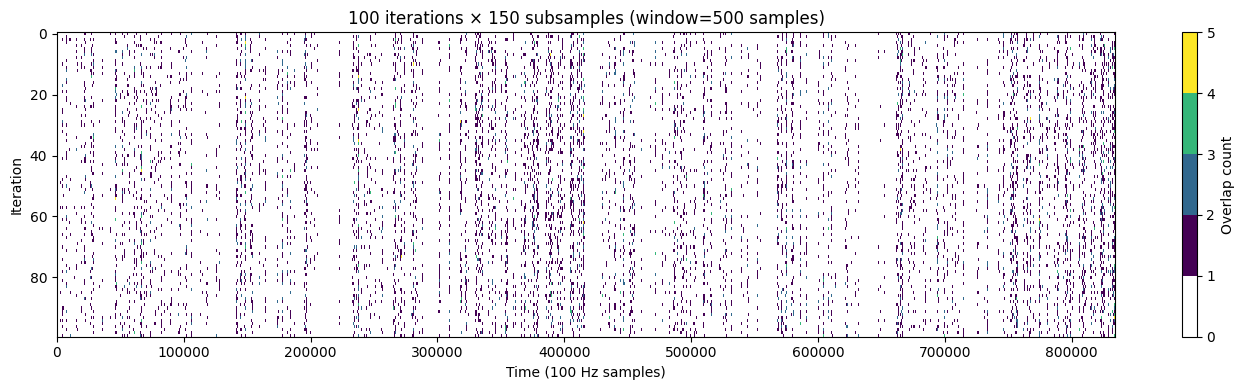

In [18]:
# Heatmap of overlap counts per iteration
fig, ax = plt.subplots(figsize=(14, 4))
im = ax.imshow(canvas, aspect='auto', interpolation='nearest', cmap=cmap, norm=norm)
if 'sentence_mask' in globals() and sentence_mask is not None:
    samples = min(canvas.shape[1], sentence_mask.shape[0])
    times_sec = mask_seconds[:samples] if mask_seconds is not None else np.arange(samples) / 100.0
    shade_mask_regions(ax, times_sec, sentence_mask[:samples], dt, label='Sentence mask')
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, loc='upper right', frameon=False)
ax.set_xlabel('Time (100 Hz samples)')
ax.set_ylabel('Iteration')
ax.set_title(f'{iterations} iterations × {n_subsamples} subsamples (window={subsample_tps} samples)')
cbar = fig.colorbar(im, ax=ax, label='Overlap count', boundaries=bounds)
cbar.locator = ticker.FixedLocator(range(0, max_overlap + 1))
cbar.formatter = ticker.FixedFormatter(range(0, max_overlap + 1))
cbar.update_ticks()
plt.tight_layout()
plt.show()


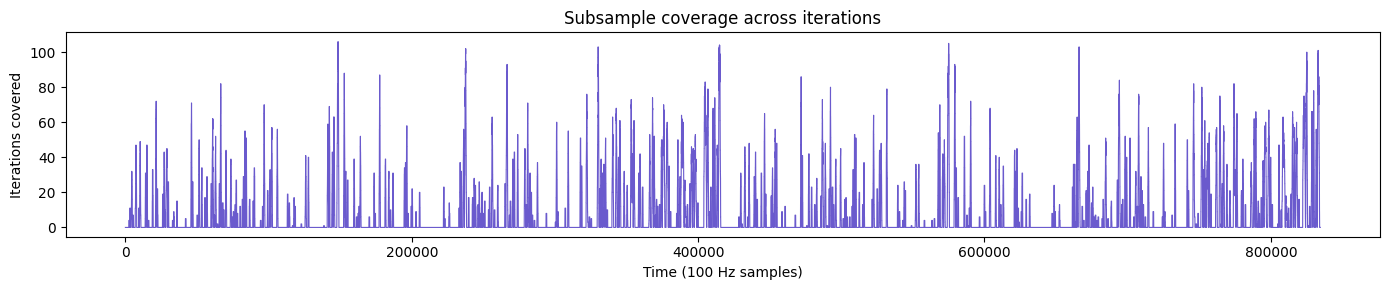

In [11]:
# Global coverage (sum across iterations); toggle `use_plot` for bars vs line
coverage = canvas.sum(axis=0)
fig, ax = plt.subplots(figsize=(14, 3))
times = np.arange(coverage.size)
use_plot = True  # set to False to use a bar plot
if use_plot:
    ax.plot(times, coverage, color='slateblue', linewidth=0.8)
else:
    ax.bar(times, coverage, width=1.0, color='slateblue')
ax.set_xlabel('Time (100 Hz samples)')
ax.set_ylabel('Iterations covered')
ax.set_title('Subsample coverage across iterations')
plt.tight_layout()
plt.show()


/var/folders/hr/kcx2z8ss1tvc10dvl9t52xbh0000gn/T/ipykernel_38512/291707920.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


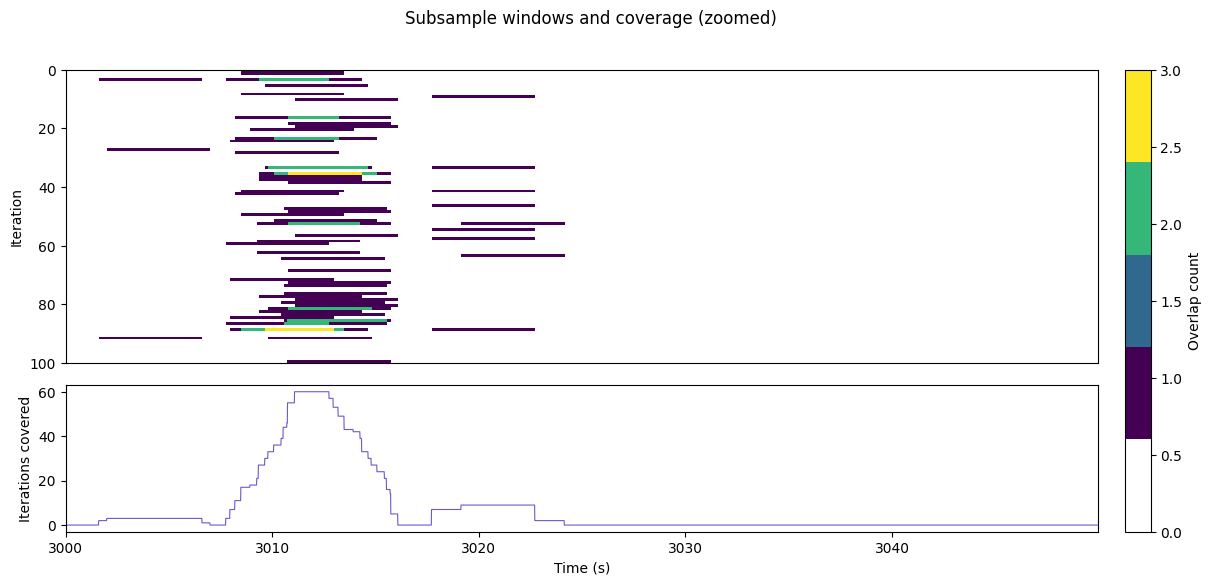

In [19]:
# Combined zoomed view in seconds
window = (300_000, 305_000)  # modify to zoom into another range
start, stop = window
start = max(0, start)
stop = min(canvas.shape[1], stop)
if stop <= start:
    raise ValueError('Invalid window; ensure stop > start within data bounds.')

sub_canvas = canvas[:, start:stop]
sub_coverage = coverage[start:stop]
zoom_samples = np.arange(start, stop)
zoom_seconds = zoom_samples / 100.0
mask_slice = sentence_mask[start:stop] if 'sentence_mask' in globals() and sentence_mask is not None else None

fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[40, 1], height_ratios=[2, 1], hspace=0.1, wspace=0.05)
ax_heat = fig.add_subplot(gs[0, 0])
ax_cov = fig.add_subplot(gs[1, 0], sharex=ax_heat)
cax = fig.add_subplot(gs[:, 1])
fig.suptitle('Subsample windows and coverage (zoomed)')

im = ax_heat.imshow(sub_canvas, aspect='auto', interpolation='nearest', cmap=cmap, norm=norm, extent=(zoom_seconds[0], zoom_seconds[-1], iterations, 0))
ax_heat.set_ylabel('Iteration')
ax_heat.set_ylim(iterations, 0)
ax_heat.xaxis.set_visible(False)
shade_mask_regions(ax_heat, zoom_seconds, mask_slice, dt, label='Sentence mask' if mask_slice is not None else None)
handles, labels = ax_heat.get_legend_handles_labels()
if handles:
        ax_heat.legend(handles, labels, loc='upper right', frameon=False)

fig.colorbar(im, cax=cax, label='Overlap count', boundaries=bounds)

ax_cov.plot(zoom_seconds, sub_coverage, color='slateblue', linewidth=0.8)
shade_mask_regions(ax_cov, zoom_seconds, mask_slice, dt, label='Sentence mask' if mask_slice is not None else None)
ax_cov.set_xlabel('Time (s)')
ax_cov.set_ylabel('Iterations covered')
ax_cov.set_xlim(zoom_seconds[0], zoom_seconds[-1])
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


/var/folders/hr/kcx2z8ss1tvc10dvl9t52xbh0000gn/T/ipykernel_38512/3795410825.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


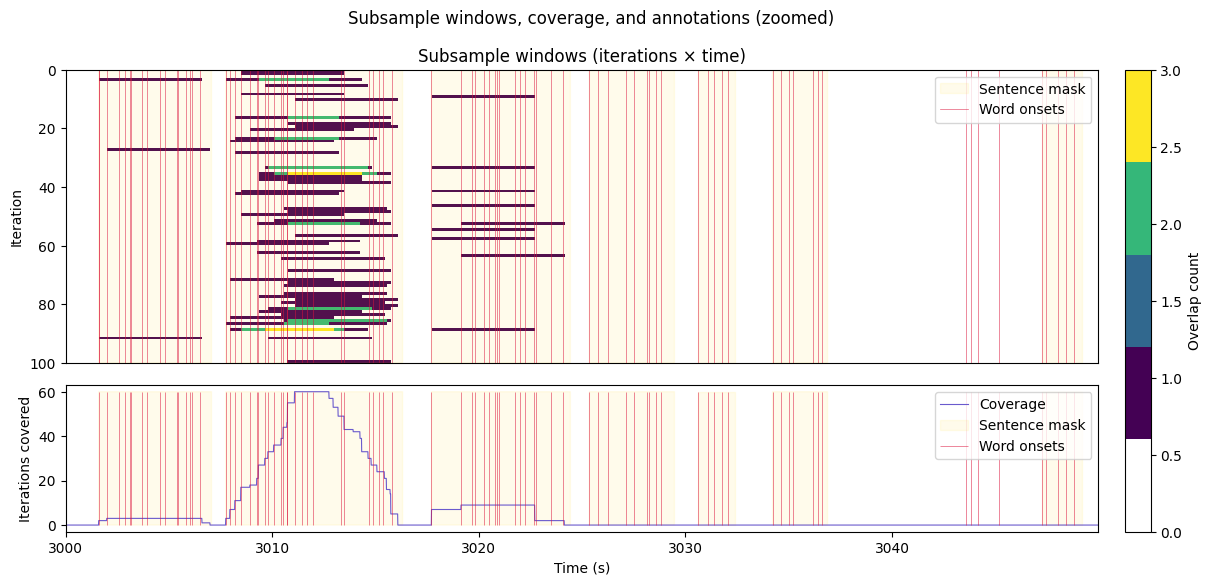

In [ ]:
# Combined zoomed view in seconds (with word onset markers)
window = (300_000, 305_000)  # modify to zoom into another range
start, stop = window
start = max(0, start)
stop = min(canvas.shape[1], stop)
if stop <= start:
    raise ValueError('Invalid window; ensure stop > start within data bounds.')

sub_canvas = canvas[:, start:stop]
sub_coverage = coverage[start:stop]
zoom_samples = np.arange(start, stop)
zoom_seconds = zoom_samples / 100.0
mask_slice = sentence_mask[start:stop] if 'sentence_mask' in globals() and sentence_mask is not None else None
onsets_in_window = subject_onsets[(subject_onsets >= zoom_seconds[0]) & (subject_onsets <= zoom_seconds[-1])] if 'subject_onsets' in globals() else np.array([])

fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[40, 1], height_ratios=[2, 1], hspace=0.1, wspace=0.05)
ax_heat = fig.add_subplot(gs[0, 0])
ax_cov = fig.add_subplot(gs[1, 0], sharex=ax_heat)
cax = fig.add_subplot(gs[:, 1])
fig.suptitle('Subsample windows, coverage, and annotations (zoomed)')

im = ax_heat.imshow(sub_canvas, aspect='auto', interpolation='nearest', cmap=cmap, norm=norm, extent=(zoom_seconds[0], zoom_seconds[-1], iterations, 0))
ax_heat.set_ylabel('Iteration')
ax_heat.set_title('Subsample windows (iterations × time)')
ax_heat.set_ylim(iterations, 0)
ax_heat.xaxis.set_visible(False)
shade_mask_regions(ax_heat, zoom_seconds, mask_slice, dt, label='Sentence mask')
for idx_onset, onset in enumerate(onsets_in_window):
    ax_heat.axvline(onset, color='crimson', linewidth=0.5, alpha=0.7, label='Word onsets' if idx_onset == 0 else None)
heat_handles, heat_labels = ax_heat.get_legend_handles_labels()
if heat_handles:
    ax_heat.legend(heat_handles, heat_labels, loc='upper right', frameon=False)
fig.colorbar(im, cax=cax, label='Overlap count', boundaries=bounds)

ax_cov.plot(zoom_seconds, sub_coverage, color='slateblue', linewidth=0.8, label='Coverage')
shade_mask_regions(ax_cov, zoom_seconds, mask_slice, dt, label='Sentence mask')
if onsets_in_window.size:
    ax_cov.vlines(onsets_in_window, ymin=0, ymax=sub_coverage.max(), color='crimson', linewidth=0.6, alpha=0.6, label='Word onsets')
ax_cov.set_xlabel('Time (s)')
ax_cov.set_ylabel('Iterations covered')
ax_cov.set_xlim(zoom_seconds[0], zoom_seconds[-1])
ax_cov.legend(loc='upper right')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
# Export a stacked diagnostic figure
output_path = cache_path.with_suffix('.png')
coverage_seconds = np.arange(coverage.size) / 100.0
total_duration = coverage_seconds[-1] if coverage_seconds.size else 0
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(6, 2, width_ratios=[40, 1], height_ratios=[3, 1.6, 0.2, 3, 1.6, 0.2], hspace=0.35, wspace=0.05)
# Panel A: global heatmap
axA = fig.add_subplot(gs[0, 0])
imA = axA.imshow(canvas, aspect='auto', interpolation='nearest', cmap=cmap, norm=norm, extent=(0, total_duration, iterations, 0))
axA.set_ylabel('Iteration')
axA.set_title('A. Subsample overlap across all iterations')
axA.set_xlim(0, total_duration)
axA.set_xticklabels([])
mask_global = None
times_global = None
if 'sentence_mask' in globals() and sentence_mask is not None:
    mask_global = sentence_mask[:coverage.size]
    times_global = mask_seconds[:mask_global.size] if mask_seconds is not None else coverage_seconds[:mask_global.size]
shade_mask_regions(axA, times_global if times_global is not None else coverage_seconds, mask_global, dt, label='Sentence mask')
handlesA, labelsA = axA.get_legend_handles_labels()
if handlesA:
    axA.legend(handlesA, labelsA, loc='upper right', frameon=False)
cbarA = fig.colorbar(imA, cax=fig.add_subplot(gs[0, 1]), label='Overlap count', boundaries=bounds)
cbarA.locator = ticker.FixedLocator(range(0, max_overlap + 1))
cbarA.formatter = ticker.FixedFormatter(range(0, max_overlap + 1))
cbarA.update_ticks()
# Panel B: full coverage
axB = fig.add_subplot(gs[1, 0], sharex=axA)
axB.plot(coverage_seconds, coverage, color='slateblue', linewidth=0.8)
axB.set_ylabel('Iterations')
axB.set_title('B. Coverage across time (100 Hz, full series)')
axB.set_xlim(0, total_duration)
axB.grid(alpha=0.2, linewidth=0.5)
axB.set_xlabel('Time (s)')
axB.xaxis.set_major_locator(ticker.MaxNLocator(6))
axB.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
axB.tick_params(axis='x', labelsize=10)
fig.add_subplot(gs[1, 1]).axis('off')
# Spacer
fig.add_subplot(gs[2, :]).axis('off')
start, stop = window
start = max(0, int(start))
stop = min(canvas.shape[1], int(stop))
if stop <= start:
    raise ValueError('Invalid window; ensure stop > start within data bounds.')
zoom_samples = np.arange(start, stop)
zoom_seconds = zoom_samples / 100.0
sub_canvas = canvas[:, start:stop]
sub_coverage = coverage[start:stop]
mask_slice = sentence_mask[start:stop] if 'sentence_mask' in globals() and sentence_mask is not None else None
onsets_in_window = subject_onsets[(subject_onsets >= zoom_seconds[0]) & (subject_onsets <= zoom_seconds[-1])] if 'subject_onsets' in globals() else np.array([])
# Panel C
axC = fig.add_subplot(gs[3, 0])
imC = axC.imshow(sub_canvas, aspect='auto', interpolation='nearest', cmap=cmap, norm=norm, extent=(zoom_seconds[0], zoom_seconds[-1], iterations, 0))
axC.set_ylabel('Iteration')
axC.set_title('C. Zoomed subsample windows')
axC.set_ylim(iterations, 0)
shade_mask_regions(axC, zoom_seconds, mask_slice, dt, label='Sentence mask')
for idx_onset, onset in enumerate(onsets_in_window):
        axC.axvline(onset, color='crimson', linewidth=0.6, alpha=0.7, label='Word onsets' if idx_onset == 0 else None)
handlesC, labelsC = axC.get_legend_handles_labels()
if handlesC:
    axC.legend(handlesC, labelsC, loc='upper right', frameon=False)
axC.set_xlim(zoom_seconds[0], zoom_seconds[-1])
axC.set_xticklabels([])
cbarC = fig.colorbar(imC, cax=fig.add_subplot(gs[3, 1]), label='Overlap count', boundaries=bounds)
cbarC.locator = ticker.FixedLocator(range(0, max_overlap + 1))
cbarC.formatter = ticker.FixedFormatter(range(0, max_overlap + 1))
cbarC.update_ticks()
# Panel D
axD = fig.add_subplot(gs[4, 0], sharex=axC)
axD.plot(zoom_seconds, sub_coverage, color='slateblue', linewidth=0.9, label='Coverage')
shade_mask_regions(axD, zoom_seconds, mask_slice, dt, label='Sentence mask')
if onsets_in_window.size:
    axD.vlines(onsets_in_window, ymin=0, ymax=sub_coverage.max(initial=0), color='crimson', linewidth=0.6, alpha=0.6, label='Word onsets')
axD.set_xlabel('Time (s)')
axD.set_ylabel('Iterations')
axD.set_title('D. Zoomed coverage with annotations')
axD.legend(loc='upper right', frameon=False)
axD.xaxis.set_major_locator(ticker.MaxNLocator(6))
axD.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
axD.tick_params(axis='x', labelsize=10)
axD.grid(alpha=0.2, linewidth=0.5)
fig.add_subplot(gs[4, 1]).axis('off')
fig.add_subplot(gs[5, :]).axis('off')
fig.suptitle('Subsampling diagnostics summary', y=0.995, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
fig.savefig(output_path, dpi=300)
print(f'Saved stacked diagnostics to {output_path.resolve()}')
